In [139]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [1]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [2]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(0, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

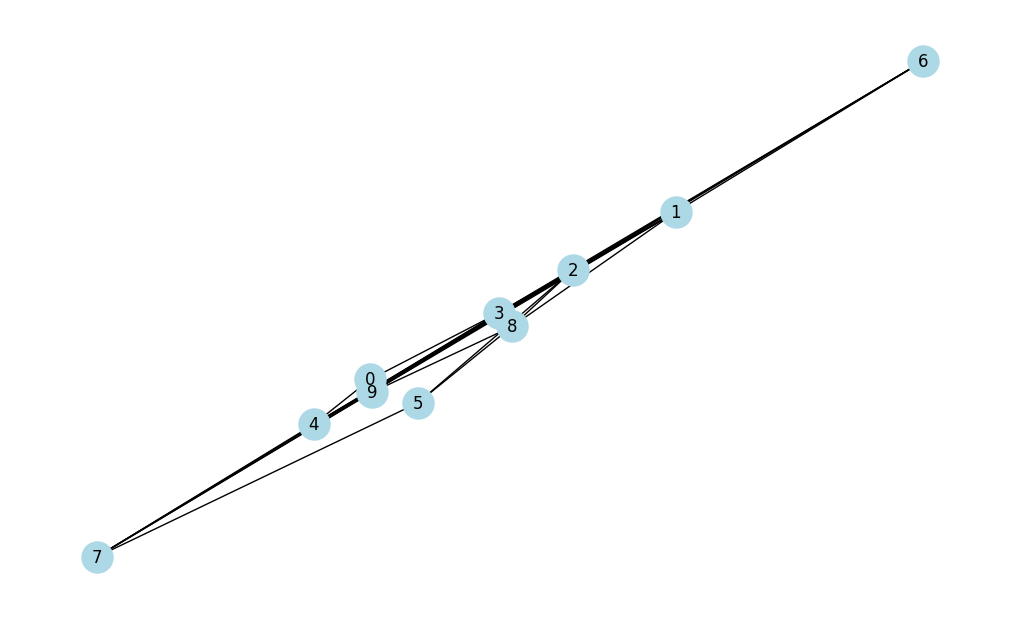

In [142]:
G = gnp_random_connected_graph(10, 0.5, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [143]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

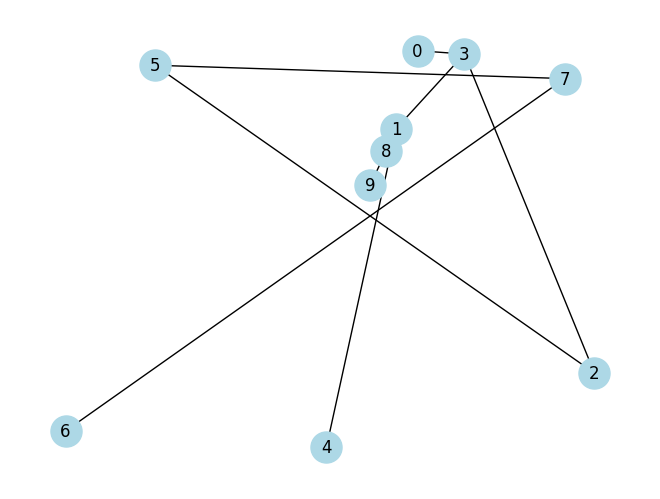

In [144]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [145]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 3), (1, 4), (1, 3), (1, 8), (2, 3), (2, 5), (5, 7), (6, 7), (8, 9)]),
 9)

*put your code below* (delete this)

### Prim's algorithm

In [146]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

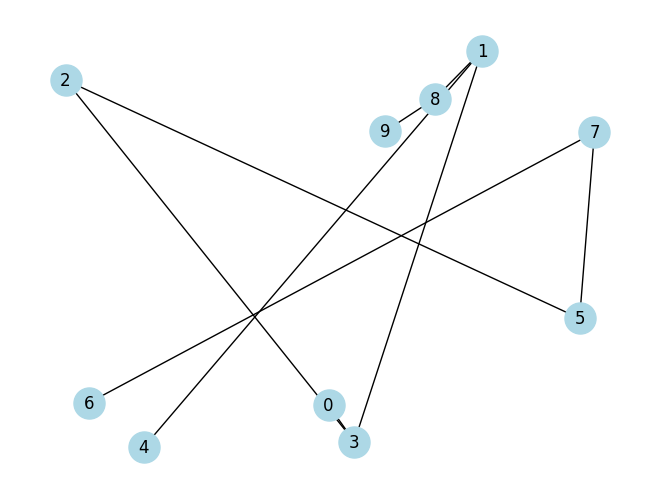

In [147]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [148]:
mstp.edges(), len(mstp.edges())

(EdgeView([(0, 3), (1, 3), (1, 4), (1, 8), (2, 3), (2, 5), (5, 7), (6, 7), (8, 9)]),
 9)

*put your code below* (delete this)

## Subtask 1.2

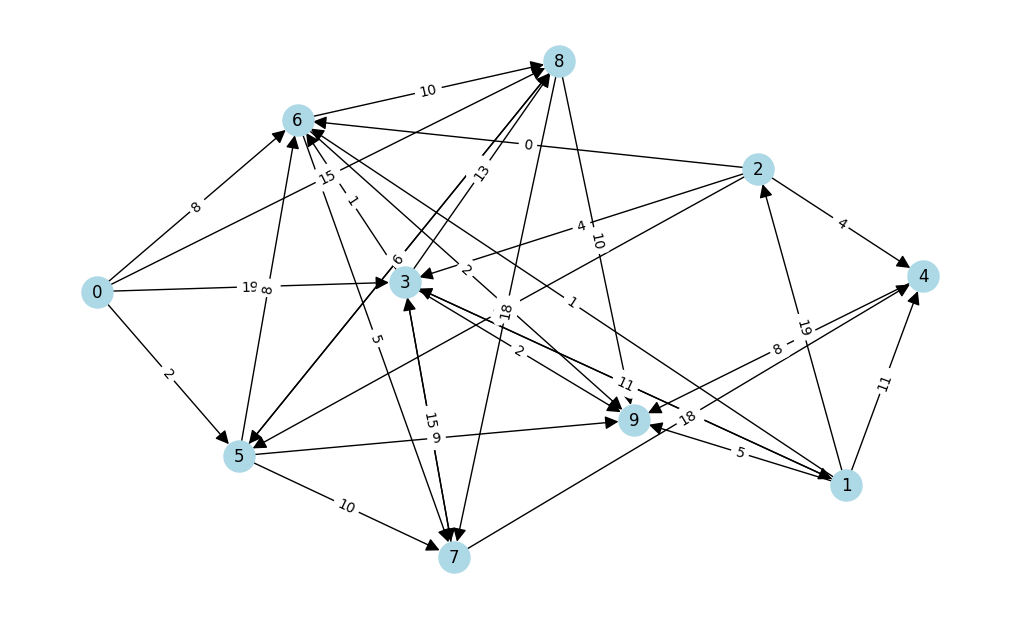

In [8]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### NetworkX Bellman-Ford algorithm

In [150]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Negative cycle detected


### Our Bellman-Ford alogirthm

In [45]:
def bellman_ford(graph, start: int):
    nodes = list(graph.nodes)
    adj = dict(graph.adjacency())

    dists = {vertex: float('inf') for vertex in nodes}
    dists[start] = 0

    preds = {node: [] for node in nodes}

    for _ in range(len(nodes) - 2):
        for vertex in nodes:
            for neighbor, weight in adj[vertex].items():
                weight = weight['weight']
                if dists[vertex] + weight <= dists[neighbor]:
                    dists[neighbor] = dists[vertex] + weight
                    if vertex not in preds[neighbor]:
                        preds[neighbor].append(vertex)

    for vertex in nodes:
        for neighbor, weight in adj[vertex].items():
            if dists[vertex] + weight['weight'] < dists[neighbor]:
                raise Exception


    dists = {node: dist for node, dist in dists.items() if dist != float('inf')}

    return preds, dists


try:
    pred, dist = bellman_ford(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")


Distance to 0: 0
Distance to 1: 0
Distance to 2: 0
Distance to 3: 0
Distance to 4: 0
Distance to 5: 0
Distance to 6: 0
Distance to 7: 0
Distance to 8: 0
Distance to 9: 0
Distance to 10: 0
Distance to 11: 0
Distance to 12: 0
Distance to 13: 0
Distance to 14: 0
Distance to 15: 0
Distance to 16: 0
Distance to 17: 0
Distance to 18: 0
Distance to 19: 0
Distance to 20: 0
Distance to 21: 0
Distance to 22: 0
Distance to 23: 0
Distance to 24: 0
Distance to 25: 0
Distance to 26: 0
Distance to 27: 0
Distance to 28: 0
Distance to 29: 0
Distance to 30: 0
Distance to 31: 0
Distance to 32: 0
Distance to 33: 0
Distance to 34: 0
Distance to 35: 0
Distance to 36: 0
Distance to 37: 0
Distance to 38: 0
Distance to 39: 0
Distance to 40: 0
Distance to 41: 0
Distance to 42: 0
Distance to 43: 0
Distance to 44: 0
Distance to 45: 0
Distance to 46: 0
Distance to 47: 0
Distance to 48: 0
Distance to 49: 0
Distance to 50: 0
Distance to 51: 0
Distance to 52: 0
Distance to 53: 0
Distance to 54: 0
Distance to 55: 0
Di

In [35]:
import time
from tqdm import tqdm

COMPLETENESSES = (0.1, 0.4, 0.8)
NUM_OF_ITERATIONS = 50
NUM_OF_NODES = (5, 10, 20, 50, 100, 150, 200, 250, 300)

In [39]:
time_bf_our = {}
time_bf_nx = {}
for completeness in COMPLETENESSES:
    time_list_our = []
    time_list_nx = []
    for nodes_num in NUM_OF_NODES:
        time_taken_our = 0
        time_taken_nx = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(nodes_num, completeness, False)
            
            start_node = list(G.nodes())[0]

            try:
                start = time.time()
                bellman_ford(G, start_node)
            except:
                pass
            finally:
                end = time.time()
                time_taken_our += end - start

            try:
                start = time.time()
                bellman_ford_predecessor_and_distance(G, start_node)
            except:
                pass
            finally:
                end = time.time()
                time_taken_nx += end - start

        avg_time_our = time_taken_our / NUM_OF_ITERATIONS
        avg_time_nx = time_taken_nx / NUM_OF_ITERATIONS
        time_list_our.append(avg_time_our)
        time_list_nx.append(avg_time_nx)
        print(f'Our average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
        print(f'NetworkX average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
    time_bf_our[completeness] = time_list_our
    time_bf_nx[completeness] = time_list_nx
    print()
print(time_bf_our)
print(time_bf_nx)

100%|██████████| 50/50 [00:00<00:00, 15749.11it/s]


Our average time per iteration: 1.178741455078125e-05 seconds for nodes_num=5 with completeness=0.1
NetworkX average time per iteration: 1.178741455078125e-05 seconds for nodes_num=5 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 9500.12it/s]


Our average time per iteration: 3.9567947387695314e-05 seconds for nodes_num=10 with completeness=0.1
NetworkX average time per iteration: 3.9567947387695314e-05 seconds for nodes_num=10 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 2711.39it/s]


Our average time per iteration: 0.0002001953125 seconds for nodes_num=20 with completeness=0.1
NetworkX average time per iteration: 0.0002001953125 seconds for nodes_num=20 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 591.82it/s]


Our average time per iteration: 0.00121828556060791 seconds for nodes_num=50 with completeness=0.1
NetworkX average time per iteration: 0.00121828556060791 seconds for nodes_num=50 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 108.45it/s]


Our average time per iteration: 0.0077003765106201175 seconds for nodes_num=100 with completeness=0.1
NetworkX average time per iteration: 0.0077003765106201175 seconds for nodes_num=100 with completeness=0.1


100%|██████████| 50/50 [00:01<00:00, 38.27it/s]


Our average time per iteration: 0.022984180450439453 seconds for nodes_num=150 with completeness=0.1
NetworkX average time per iteration: 0.022984180450439453 seconds for nodes_num=150 with completeness=0.1


100%|██████████| 50/50 [00:03<00:00, 14.97it/s]


Our average time per iteration: 0.05519001007080078 seconds for nodes_num=200 with completeness=0.1
NetworkX average time per iteration: 0.05519001007080078 seconds for nodes_num=200 with completeness=0.1


100%|██████████| 50/50 [00:05<00:00,  8.69it/s]


Our average time per iteration: 0.10631883144378662 seconds for nodes_num=250 with completeness=0.1
NetworkX average time per iteration: 0.10631883144378662 seconds for nodes_num=250 with completeness=0.1


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


Our average time per iteration: 0.17478230953216553 seconds for nodes_num=300 with completeness=0.1
NetworkX average time per iteration: 0.17478230953216553 seconds for nodes_num=300 with completeness=0.1



100%|██████████| 50/50 [00:00<00:00, 31583.61it/s]


Our average time per iteration: 7.448196411132812e-06 seconds for nodes_num=5 with completeness=0.4
NetworkX average time per iteration: 7.448196411132812e-06 seconds for nodes_num=5 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 10535.28it/s]


Our average time per iteration: 3.660202026367188e-05 seconds for nodes_num=10 with completeness=0.4
NetworkX average time per iteration: 3.660202026367188e-05 seconds for nodes_num=10 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 2441.05it/s]


Our average time per iteration: 0.00023068904876708985 seconds for nodes_num=20 with completeness=0.4
NetworkX average time per iteration: 0.00023068904876708985 seconds for nodes_num=20 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 244.44it/s]


Our average time per iteration: 0.003080596923828125 seconds for nodes_num=50 with completeness=0.4
NetworkX average time per iteration: 0.003080596923828125 seconds for nodes_num=50 with completeness=0.4


100%|██████████| 50/50 [00:01<00:00, 37.56it/s]


Our average time per iteration: 0.022831554412841796 seconds for nodes_num=100 with completeness=0.4
NetworkX average time per iteration: 0.022831554412841796 seconds for nodes_num=100 with completeness=0.4


100%|██████████| 50/50 [00:04<00:00, 11.33it/s]


Our average time per iteration: 0.07920872688293457 seconds for nodes_num=150 with completeness=0.4
NetworkX average time per iteration: 0.07920872688293457 seconds for nodes_num=150 with completeness=0.4


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


Our average time per iteration: 0.18305797576904298 seconds for nodes_num=200 with completeness=0.4
NetworkX average time per iteration: 0.18305797576904298 seconds for nodes_num=200 with completeness=0.4


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


Our average time per iteration: 0.3522901964187622 seconds for nodes_num=250 with completeness=0.4
NetworkX average time per iteration: 0.3522901964187622 seconds for nodes_num=250 with completeness=0.4


100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


Our average time per iteration: 0.6208218145370483 seconds for nodes_num=300 with completeness=0.4
NetworkX average time per iteration: 0.6208218145370483 seconds for nodes_num=300 with completeness=0.4



100%|██████████| 50/50 [00:00<00:00, 27902.50it/s]


Our average time per iteration: 8.230209350585938e-06 seconds for nodes_num=5 with completeness=0.8
NetworkX average time per iteration: 8.230209350585938e-06 seconds for nodes_num=5 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 8001.34it/s]


Our average time per iteration: 4.840850830078125e-05 seconds for nodes_num=10 with completeness=0.8
NetworkX average time per iteration: 4.840850830078125e-05 seconds for nodes_num=10 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 1547.12it/s]


Our average time per iteration: 0.0003679084777832031 seconds for nodes_num=20 with completeness=0.8
NetworkX average time per iteration: 0.0003679084777832031 seconds for nodes_num=20 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 143.11it/s]


Our average time per iteration: 0.005350737571716308 seconds for nodes_num=50 with completeness=0.8
NetworkX average time per iteration: 0.005350737571716308 seconds for nodes_num=50 with completeness=0.8


100%|██████████| 50/50 [00:02<00:00, 21.31it/s]


Our average time per iteration: 0.04128614902496338 seconds for nodes_num=100 with completeness=0.8
NetworkX average time per iteration: 0.04128614902496338 seconds for nodes_num=100 with completeness=0.8


100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Our average time per iteration: 0.14282684803009033 seconds for nodes_num=150 with completeness=0.8
NetworkX average time per iteration: 0.14282684803009033 seconds for nodes_num=150 with completeness=0.8


100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


Our average time per iteration: 0.36849226951599123 seconds for nodes_num=200 with completeness=0.8
NetworkX average time per iteration: 0.36849226951599123 seconds for nodes_num=200 with completeness=0.8


100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


Our average time per iteration: 0.7287544631958007 seconds for nodes_num=250 with completeness=0.8
NetworkX average time per iteration: 0.7287544631958007 seconds for nodes_num=250 with completeness=0.8


100%|██████████| 50/50 [01:06<00:00,  1.33s/it]

Our average time per iteration: 1.2804968500137328 seconds for nodes_num=300 with completeness=0.8
NetworkX average time per iteration: 1.2804968500137328 seconds for nodes_num=300 with completeness=0.8

{0.1: [1.178741455078125e-05, 3.9567947387695314e-05, 0.0002001953125, 0.00121828556060791, 0.0077003765106201175, 0.022984180450439453, 0.05519001007080078, 0.10631883144378662, 0.17478230953216553], 0.4: [7.448196411132812e-06, 3.660202026367188e-05, 0.00023068904876708985, 0.003080596923828125, 0.022831554412841796, 0.07920872688293457, 0.18305797576904298, 0.3522901964187622, 0.6208218145370483], 0.8: [8.230209350585938e-06, 4.840850830078125e-05, 0.0003679084777832031, 0.005350737571716308, 0.04128614902496338, 0.14282684803009033, 0.36849226951599123, 0.7287544631958007, 1.2804968500137328]}
{0.1: [1.220703125e-05, 1.8415451049804686e-05, 4.8732757568359376e-05, 0.00013175010681152344, 0.0004060649871826172, 0.0008551549911499024, 0.0016545915603637695, 0.0027253532409667967, 0.0

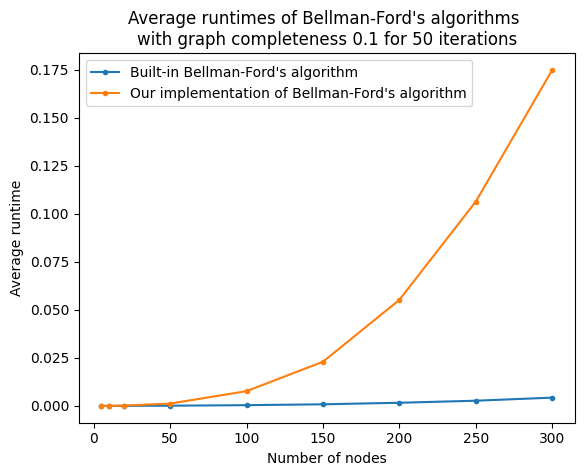

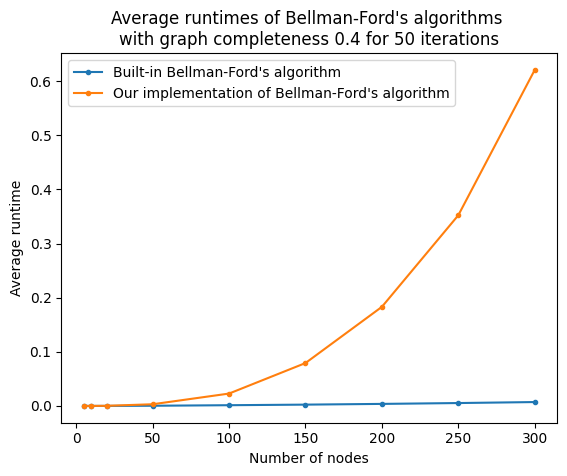

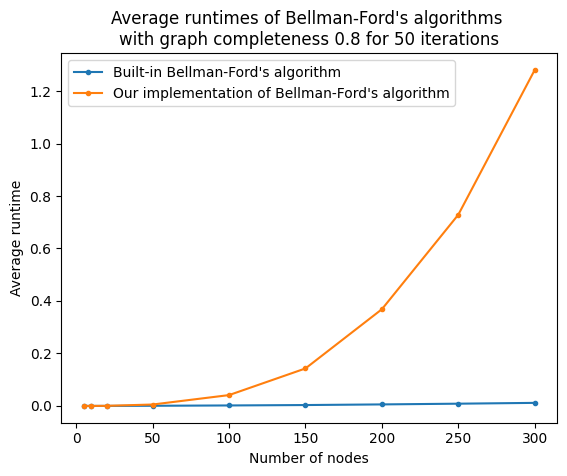

In [41]:
for completeness in COMPLETENESSES:
    plt.plot(NUM_OF_NODES, time_bf_nx[completeness], label="Built-in Bellman-Ford's algorithm", marker='.')
    plt.plot(NUM_OF_NODES, time_bf_our[completeness], label="Our implementation of Bellman-Ford's algorithm", marker='.')
    plt.xlabel('Number of nodes')
    plt.ylabel('Average runtime')
    plt.title(f"Average runtimes of Bellman-Ford's algorithms \nwith graph completeness {completeness} for {NUM_OF_ITERATIONS} iterations")
    plt.legend()
    plt.show()

### NetworkX Floyd-Warshall algorithm

In [3]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Negative cycle detected


### Our Floyd-Warshall algorithm

In [32]:
def floyd_warshall(graph):
    nodes = list(graph.nodes)
    adj = dict(graph.adjacency())

    dists = {u: {v: float('inf') for v in nodes} for u in nodes}
    preds = {u: {v: None for v in nodes if v != u} for u in nodes}

    for u in nodes:
        for v, weight in adj[u].items():
            dists[u][v] = weight['weight']
            preds[u][v] = u
        dists[u][u] = 0

    for k in nodes:
        for i in nodes:
            for j in nodes:
                if dists[i][j] > dists[i][k] + dists[k][j]:
                    dists[i][j] = dists[i][k] + dists[k][j]
                    preds[i][j] = preds[k][j]
                if i == j and dists[i][j] < 0:
                    raise Exception

    return preds, dists

try:
    pred, dist = floyd_warshall(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 1: 41, 2: 9, 3: 47, 4: 27}
Distances with 1 source: {0: 41, 1: 0, 2: 32, 3: 34, 4: 14}
Distances with 2 source: {0: 9, 1: 32, 2: 0, 3: 38, 4: 18}
Distances with 3 source: {0: 47, 1: 34, 2: 38, 3: 0, 4: 20}
Distances with 4 source: {0: 27, 1: 14, 2: 18, 3: 20, 4: 0}


---

In [43]:
import time
from tqdm import tqdm

COMPLETENESSES = (0.1, 0.4, 0.8)
NUM_OF_ITERATIONS = 50
NUM_OF_NODES = (5, 10, 20, 50, 100, 150, 200)

In [33]:
time_fw_our = {}
time_fw_nx = {}
for completeness in COMPLETENESSES:
    time_list_our = []
    time_list_nx = []
    for nodes_num in NUM_OF_NODES:
        time_taken_our = 0
        time_taken_nx = 0
        for i in tqdm(range(NUM_OF_ITERATIONS)):
            G = gnp_random_connected_graph(nodes_num, completeness, False)
            
            try:
                start = time.time()
                floyd_warshall(G)
            except KeyboardInterrupt:
                pass
            finally:
                end = time.time()
                time_taken_our += end - start

            try:
                start = time.time()
                floyd_warshall_predecessor_and_distance(G)
            except:
                pass
            finally:
                end = time.time()
                time_taken_nx += end - start

        avg_time_our = time_taken_our / NUM_OF_ITERATIONS
        avg_time_nx = time_taken_nx / NUM_OF_ITERATIONS
        time_list_our.append(avg_time_our)
        time_list_nx.append(avg_time_nx)
        print(f'Our average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
        print(f'NetworkX average time per iteration: {avg_time_our} seconds for {nodes_num=} with {completeness=}')
    time_fw_our[completeness] = time_list_our
    time_fw_nx[completeness] = time_list_nx
    print()
print(time_fw_our)
print(time_fw_nx)

100%|██████████| 50/50 [00:00<00:00, 11268.95it/s]


Our average time per iteration: 3.0279159545898438e-05 seconds for nodes_num=5 with completeness=0.1
NetworkX average time per iteration: 3.0279159545898438e-05 seconds for nodes_num=5 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 2889.16it/s]


Our average time per iteration: 0.0001607370376586914 seconds for nodes_num=10 with completeness=0.1
NetworkX average time per iteration: 0.0001607370376586914 seconds for nodes_num=10 with completeness=0.1


100%|██████████| 50/50 [00:00<00:00, 604.59it/s]


Our average time per iteration: 0.000883941650390625 seconds for nodes_num=20 with completeness=0.1
NetworkX average time per iteration: 0.000883941650390625 seconds for nodes_num=20 with completeness=0.1


100%|██████████| 50/50 [00:01<00:00, 49.26it/s]


Our average time per iteration: 0.011710529327392577 seconds for nodes_num=50 with completeness=0.1
NetworkX average time per iteration: 0.011710529327392577 seconds for nodes_num=50 with completeness=0.1


100%|██████████| 50/50 [00:07<00:00,  6.82it/s]


Our average time per iteration: 0.08740264415740967 seconds for nodes_num=100 with completeness=0.1
NetworkX average time per iteration: 0.08740264415740967 seconds for nodes_num=100 with completeness=0.1


100%|██████████| 50/50 [00:24<00:00,  2.06it/s]


Our average time per iteration: 0.29148797035217283 seconds for nodes_num=150 with completeness=0.1
NetworkX average time per iteration: 0.29148797035217283 seconds for nodes_num=150 with completeness=0.1


100%|██████████| 50/50 [00:56<00:00,  1.14s/it]


Our average time per iteration: 0.6936458730697632 seconds for nodes_num=200 with completeness=0.1
NetworkX average time per iteration: 0.6936458730697632 seconds for nodes_num=200 with completeness=0.1



100%|██████████| 50/50 [00:00<00:00, 14710.66it/s]


Our average time per iteration: 1.8787384033203124e-05 seconds for nodes_num=5 with completeness=0.4
NetworkX average time per iteration: 1.8787384033203124e-05 seconds for nodes_num=5 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 3306.45it/s]


Our average time per iteration: 0.00012947559356689452 seconds for nodes_num=10 with completeness=0.4
NetworkX average time per iteration: 0.00012947559356689452 seconds for nodes_num=10 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 615.19it/s]


Our average time per iteration: 0.0008431005477905273 seconds for nodes_num=20 with completeness=0.4
NetworkX average time per iteration: 0.0008431005477905273 seconds for nodes_num=20 with completeness=0.4


100%|██████████| 50/50 [00:00<00:00, 50.11it/s]


Our average time per iteration: 0.011416730880737304 seconds for nodes_num=50 with completeness=0.4
NetworkX average time per iteration: 0.011416730880737304 seconds for nodes_num=50 with completeness=0.4


100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Our average time per iteration: 0.08640925407409668 seconds for nodes_num=100 with completeness=0.4
NetworkX average time per iteration: 0.08640925407409668 seconds for nodes_num=100 with completeness=0.4


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Our average time per iteration: 0.2794058465957642 seconds for nodes_num=150 with completeness=0.4
NetworkX average time per iteration: 0.2794058465957642 seconds for nodes_num=150 with completeness=0.4


100%|██████████| 50/50 [00:54<00:00,  1.10s/it]


Our average time per iteration: 0.6671363544464112 seconds for nodes_num=200 with completeness=0.4
NetworkX average time per iteration: 0.6671363544464112 seconds for nodes_num=200 with completeness=0.4



100%|██████████| 50/50 [00:00<00:00, 14522.21it/s]


Our average time per iteration: 1.826763153076172e-05 seconds for nodes_num=5 with completeness=0.8
NetworkX average time per iteration: 1.826763153076172e-05 seconds for nodes_num=5 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 1371.66it/s]


Our average time per iteration: 0.0003556966781616211 seconds for nodes_num=10 with completeness=0.8
NetworkX average time per iteration: 0.0003556966781616211 seconds for nodes_num=10 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 597.43it/s]


Our average time per iteration: 0.0008098745346069336 seconds for nodes_num=20 with completeness=0.8
NetworkX average time per iteration: 0.0008098745346069336 seconds for nodes_num=20 with completeness=0.8


100%|██████████| 50/50 [00:00<00:00, 50.05it/s]


Our average time per iteration: 0.0111836576461792 seconds for nodes_num=50 with completeness=0.8
NetworkX average time per iteration: 0.0111836576461792 seconds for nodes_num=50 with completeness=0.8


100%|██████████| 50/50 [00:07<00:00,  7.11it/s]


Our average time per iteration: 0.08275023460388184 seconds for nodes_num=100 with completeness=0.8
NetworkX average time per iteration: 0.08275023460388184 seconds for nodes_num=100 with completeness=0.8


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Our average time per iteration: 0.26996312618255613 seconds for nodes_num=150 with completeness=0.8
NetworkX average time per iteration: 0.26996312618255613 seconds for nodes_num=150 with completeness=0.8


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

Our average time per iteration: 0.6473222398757934 seconds for nodes_num=200 with completeness=0.8
NetworkX average time per iteration: 0.6473222398757934 seconds for nodes_num=200 with completeness=0.8

{0.1: [3.0279159545898438e-05, 0.0001607370376586914, 0.000883941650390625, 0.011710529327392577, 0.08740264415740967, 0.29148797035217283, 0.6936458730697632], 0.4: [1.8787384033203124e-05, 0.00012947559356689452, 0.0008431005477905273, 0.011416730880737304, 0.08640925407409668, 0.2794058465957642, 0.6671363544464112], 0.8: [1.826763153076172e-05, 0.0003556966781616211, 0.0008098745346069336, 0.0111836576461792, 0.08275023460388184, 0.26996312618255613, 0.6473222398757934]}
{0.1: [3.078937530517578e-05, 0.00013669967651367188, 0.0006594085693359376, 0.008082995414733887, 0.05725457191467285, 0.19089454650878906, 0.4383338785171509], 0.4: [2.002716064453125e-05, 0.00011092662811279297, 0.0006260442733764649, 0.007704544067382813, 0.05523478031158447, 0.17822630882263182, 0.420390453338

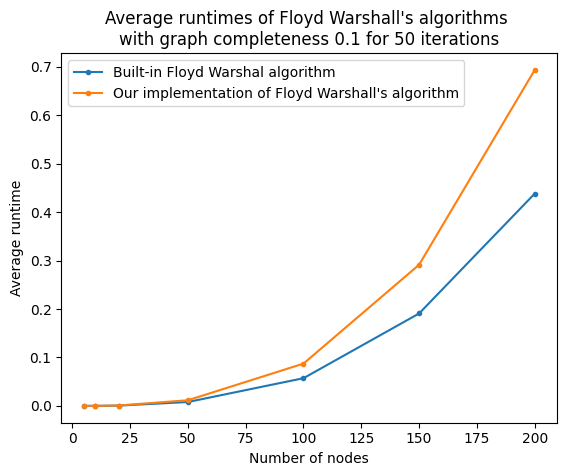

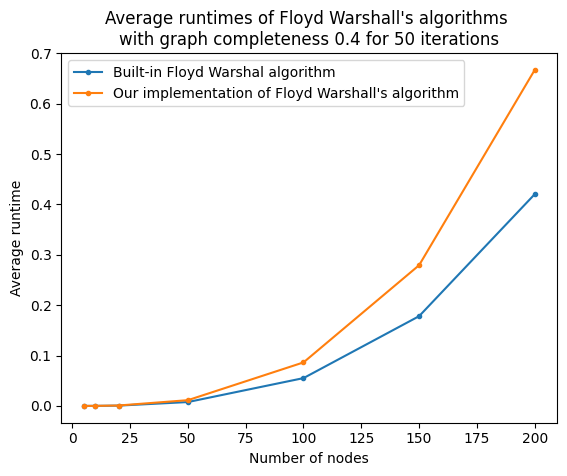

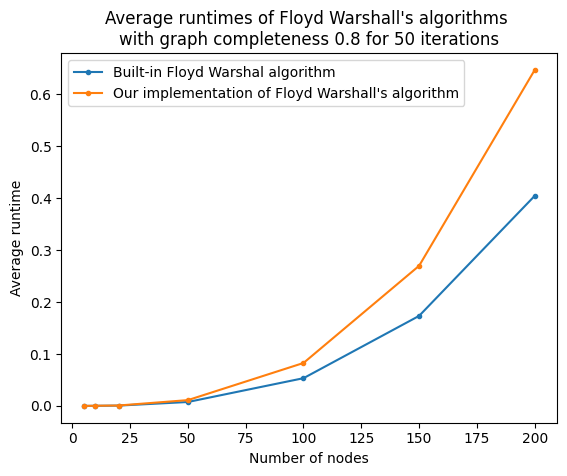

In [44]:
for completeness in COMPLETENESSES:
    plt.plot(NUM_OF_NODES, time_fw_nx[completeness], label="Built-in Floyd Warshal algorithm", marker='.')
    plt.plot(NUM_OF_NODES, time_fw_our[completeness], label="Our implementation of Floyd Warshall's algorithm", marker='.')
    plt.xlabel('Number of nodes')
    plt.ylabel('Average runtime')
    plt.title(f"Average runtimes of Floyd Warshall's algorithms \nwith graph completeness {completeness} for {NUM_OF_ITERATIONS} iterations")
    plt.legend()
    plt.show()

## Task 2. Decision Tree Classifier 

In [21]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [22]:
# Load dataset
iris = load_iris()
dir(iris)

['DESCR',
 'data',
 'data_module',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [23]:
iris.data.shape

(150, 4)

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [24]:
iris.data[0:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2]])

### To undestand data little bit better, let's plot some features

Text(0, 0.5, 'Sepal width')

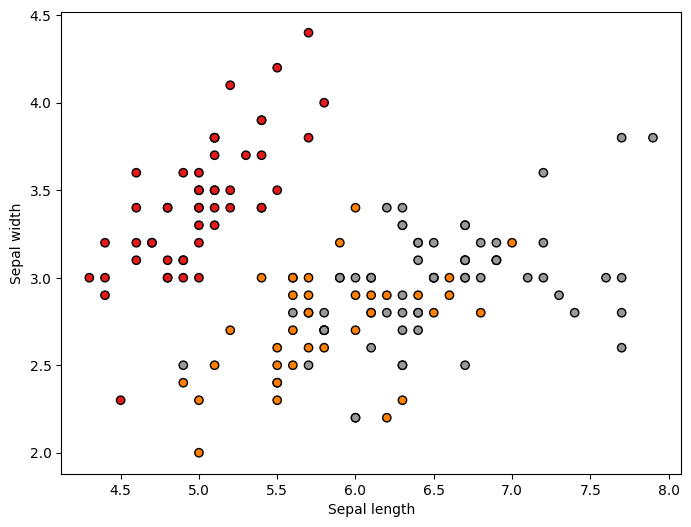

In [25]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [26]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

((150, 4), (150,))

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [27]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

((30, 4), (30,))

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [28]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [29]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

'iris.pdf'

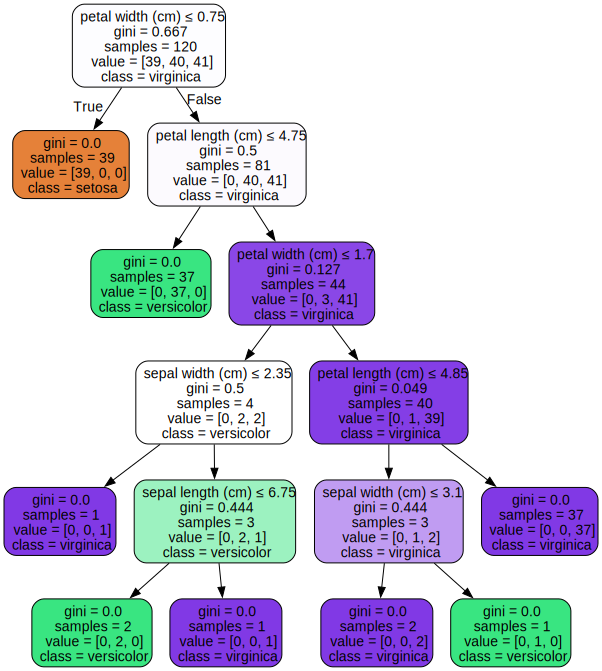

In [30]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [31]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [32]:
sum(predictions == y_test) / len(y_test)

np.float64(0.8)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [33]:
y_test

array([2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0,
       1, 2, 1, 0, 1, 1, 0, 2])


Here you can traverse the tree above by yourself and make sure that prediction works

In [34]:
X_test[1]

array([4.9, 3.1, 1.5, 0.2])

In [35]:
clf.predict([X_test[1]])

array([0])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [36]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [37]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size


    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass

In [38]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)